In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from skimage import io



In [2]:
annotations_file = 'annotations_imSize.csv'

In [3]:
anno = pd.read_csv(annotations_file)
anno.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480


In [4]:
minValue = anno[['width', 'height']].min()
print(minValue)

maxValue = anno[['width', 'height']].max()
print(maxValue)

width     640
height    480
dtype: int64
width     704
height    480
dtype: int64


In [5]:
anno.value_counts("width")

width
704    673
640    227
dtype: int64

In [6]:
anno.value_counts("height")

height
480    900
dtype: int64

In [7]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [8]:
# Code for plotting bounding box
def plot_bbox(img_id):
  img_url = img_id
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = anno[anno['filename']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['x1']
      xmax = row['x2']
      ymin = row['y1']
      ymax = row['y2']
      label_name = row['class']
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, label_name, (xmin,ymin-10), font, 1, (0,255,0), 2)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [9]:
# sz = 300

# im = read_image("db_lisa_tiny/sample_001.png")
# im_resized = cv2.resize(im, (int(1.49*sz), sz))

# Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))



In [10]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [11]:
def create_bb_array(x):
    """Generates bounding box array from a anno row"""
    return np.array([x[2],x[1],x[4],x[3]])

In [12]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = r'{}/{}'.format(write_path,read_path)
    print(new_path)
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [13]:
anno.loc[0].values

array(['db_lisa_tiny/sample_001.png', 190, 40, 211, 63, 'stop', 'Train',
       704, 480], dtype=object)

In [14]:
a = anno.loc[0].values
b = create_bb_array(a)

c, d = resize_image_bb('db_lisa_tiny/sample_001.png',"lisa_resize/abc.jpg",b , 300)

c
d

lisa_resize/abc.jpg/db_lisa_tiny/sample_001.png


C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


array([ 25., 120.,  39., 133.], dtype=float32)

In [15]:
train_path_resized = Path('lisa_resize')
print(type(train_path_resized))

<class 'pathlib.WindowsPath'>


In [16]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = 'lisa_resize'
for index, row in anno.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
anno['new_path'] = new_paths
anno['new_bb'] = new_bbs

C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


lisa_resize/db_lisa_tiny/sample_001.png
lisa_resize/db_lisa_tiny/sample_002.png
lisa_resize/db_lisa_tiny/sample_003.png
lisa_resize/db_lisa_tiny/sample_004.png
lisa_resize/db_lisa_tiny/sample_005.png
lisa_resize/db_lisa_tiny/sample_006.png
lisa_resize/db_lisa_tiny/sample_007.png
lisa_resize/db_lisa_tiny/sample_008.png
lisa_resize/db_lisa_tiny/sample_009.png
lisa_resize/db_lisa_tiny/sample_010.png
lisa_resize/db_lisa_tiny/sample_011.png
lisa_resize/db_lisa_tiny/sample_012.png
lisa_resize/db_lisa_tiny/sample_013.png
lisa_resize/db_lisa_tiny/sample_014.png
lisa_resize/db_lisa_tiny/sample_015.png
lisa_resize/db_lisa_tiny/sample_016.png
lisa_resize/db_lisa_tiny/sample_017.png
lisa_resize/db_lisa_tiny/sample_018.png
lisa_resize/db_lisa_tiny/sample_019.png
lisa_resize/db_lisa_tiny/sample_020.png
lisa_resize/db_lisa_tiny/sample_021.png
lisa_resize/db_lisa_tiny/sample_022.png
lisa_resize/db_lisa_tiny/sample_023.png
lisa_resize/db_lisa_tiny/sample_024.png
lisa_resize/db_lisa_tiny/sample_025.png


In [17]:
anno

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]"
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]"
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]"
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]"
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]"
...,...,...,...,...,...,...,...,...,...,...,...
895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]"
896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]"
897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]"
898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]"


In [18]:
width_list = []
height_list = []

for i in anno["new_path"]:
    image = Image.open(i)

    width, height = image.size
    
    width_list.append(width)
    height_list.append(height)

# Insert width and height of images to annotations data frame
anno['new_width'] = width_list
anno['new_height'] = height_list

anno.head()

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300


In [19]:
anno.value_counts("new_width")

new_width
447    900
dtype: int64

In [20]:
anno.value_counts("new_height")

new_height
300    900
dtype: int64

In [21]:
im = cv2.imread("db_lisa_tiny/sample_001.png")
bb = create_bb_array(anno.values[0])
print(im.shape)

(480, 704, 3)


In [22]:
Y = create_mask(bb, im)
mask_to_bb(Y)


C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


array([ 40., 190.,  62., 210.], dtype=float32)

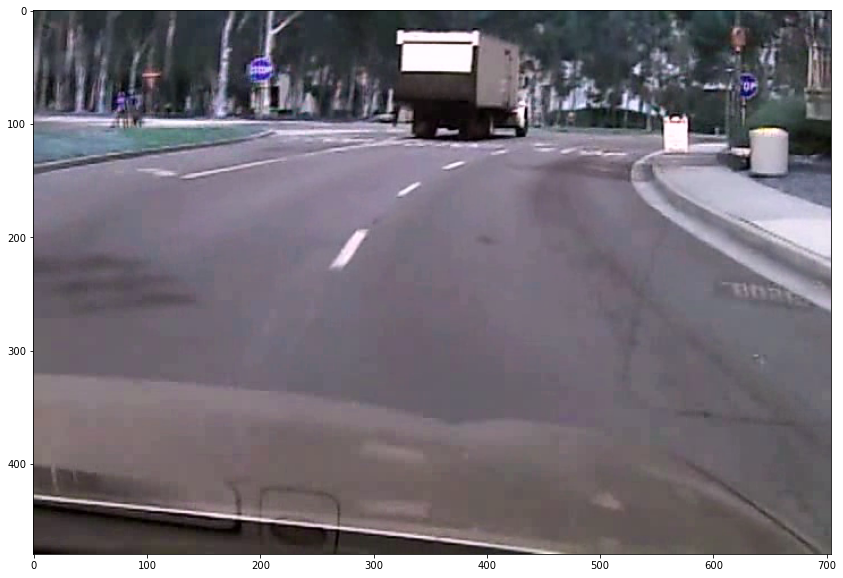

In [23]:
plt.figure(figsize=(15,10))
plt.imshow(im)

Image: (480, 704, 3)
Coordinates: (190, 40), (211, 63)


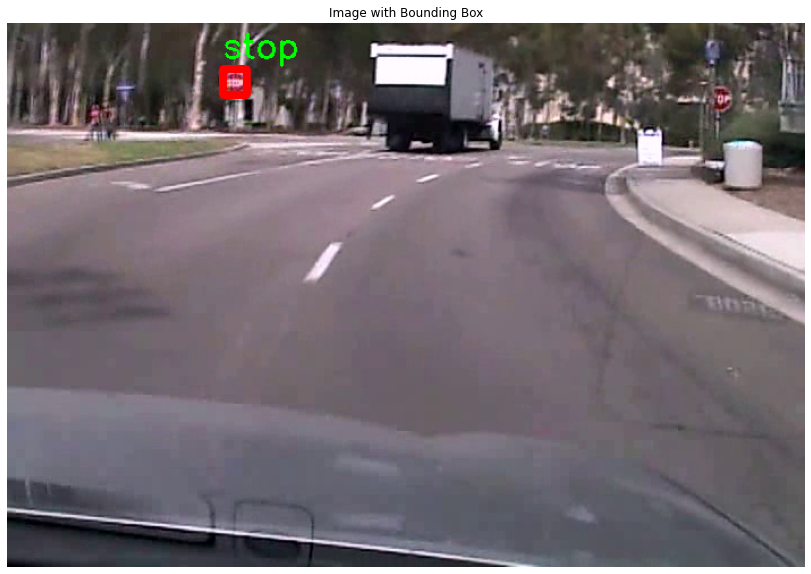

In [24]:
plot_bbox("db_lisa_tiny/sample_001.png")

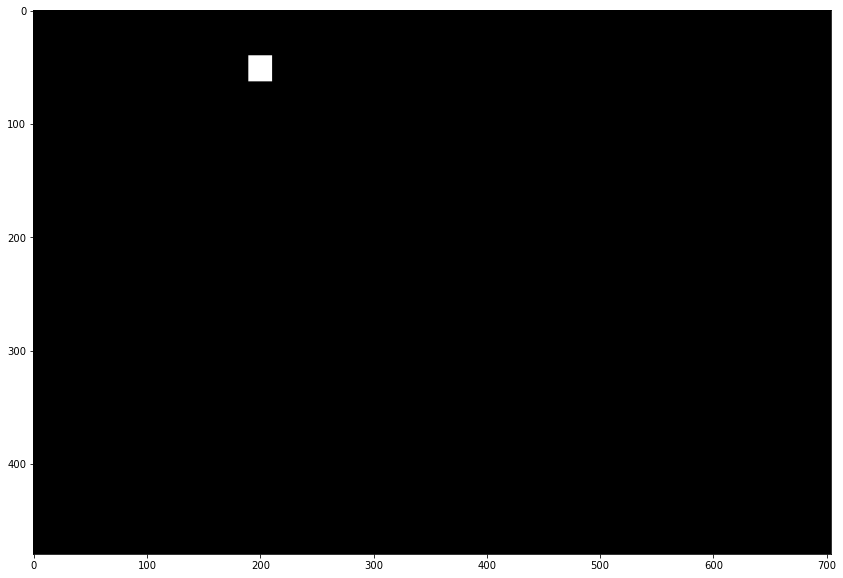

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(Y, cmap='gray')


In [26]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [27]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [28]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.figure(figsize=(15,10))
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

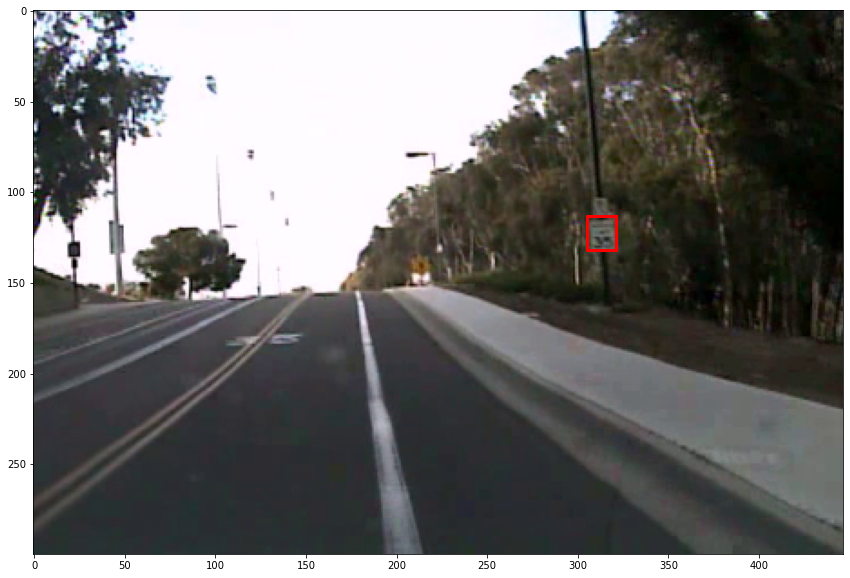

In [29]:
im_num = random.randint(0, 900)
im = cv2.imread(str(anno.values[im_num][9]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, anno.values[im_num][10])

C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


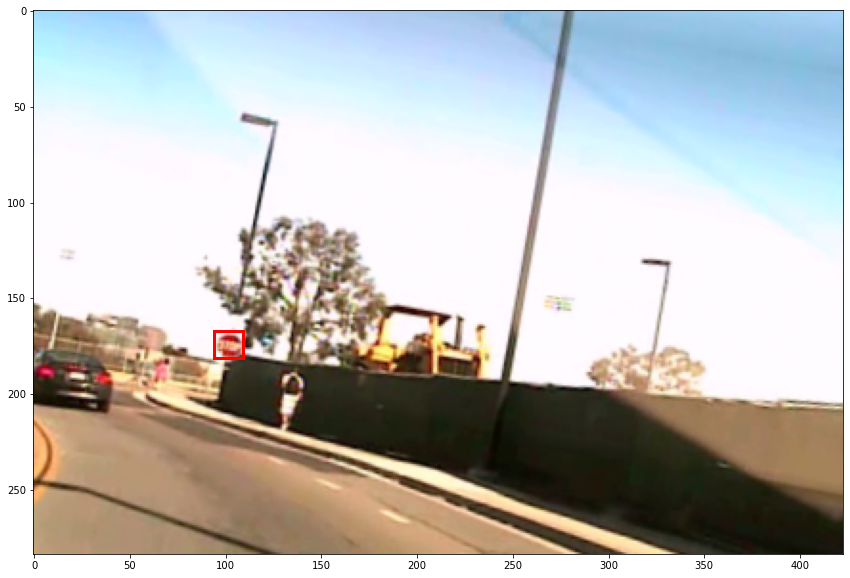

In [30]:
im, bb = transformsXY(str(anno.values[68][9]),anno.values[68][10],True )
show_corner_bb(im, bb)

In [31]:
anno.value_counts("class")

class
stop                  210
keepRight             110
speedLimit35          110
merge                 100
pedestrianCrossing    100
signalAhead           100
speedLimit25           80
yield                  45
yieldAhead             45
dtype: int64

In [32]:
unique = anno["class"].unique()
unique

array(['stop', 'yield', 'yieldAhead', 'merge', 'signalAhead',
       'pedestrianCrossing', 'keepRight', 'speedLimit35', 'speedLimit25'],
      dtype=object)

In [33]:
#Convert classes to dict and reverse key value pair
unique_enum = enumerate(unique)
unique_enum = dict(unique_enum)
unique_enum = {v: k for k, v in unique_enum.items()}
unique_enum

{'stop': 0,
 'yield': 1,
 'yieldAhead': 2,
 'merge': 3,
 'signalAhead': 4,
 'pedestrianCrossing': 5,
 'keepRight': 6,
 'speedLimit35': 7,
 'speedLimit25': 8}

In [34]:
# Create a column named Class Index
class_idx = []
for rows in anno["class"]:
    class_idx.append(unique_enum[rows])

anno["class_idx"] = class_idx

anno
    

,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height,class_idx
0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300,0
1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300,0
2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300,0
3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300,0
4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]",447,300,8
896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]",447,300,8
897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]",447,300,8
898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]",447,300,8


In [35]:
df_train = anno.reset_index()

In [36]:
df_train

,index,filename,x1,y1,x2,y2,class,Train/Test,width,height,new_path,new_bb,new_width,new_height,class_idx
0,0,db_lisa_tiny/sample_001.png,190,40,211,63,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_001.png,"[25.0, 120.0, 39.0, 133.0]",447,300,0
1,1,db_lisa_tiny/sample_002.png,4,246,43,283,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_002.png,"[153.0, 2.0, 176.0, 27.0]",447,300,0
2,2,db_lisa_tiny/sample_003.png,389,286,418,314,stop,Train,704,480,lisa_resize/db_lisa_tiny/sample_003.png,"[178.0, 247.0, 196.0, 265.0]",447,300,0
3,3,db_lisa_tiny/sample_004.png,307,243,315,251,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_004.png,"[152.0, 214.0, 156.0, 219.0]",447,300,0
4,4,db_lisa_tiny/sample_005.png,377,249,398,270,stop,Train,640,480,lisa_resize/db_lisa_tiny/sample_005.png,"[155.0, 263.0, 168.0, 277.0]",447,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,db_lisa_tiny/sample_896.png,534,155,563,187,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_896.png,"[97.0, 339.0, 116.0, 357.0]",447,300,8
896,896,db_lisa_tiny/sample_897.png,526,223,540,240,speedLimit25,Train,640,480,lisa_resize/db_lisa_tiny/sample_897.png,"[139.0, 367.0, 149.0, 377.0]",447,300,8
897,897,db_lisa_tiny/sample_898.png,633,236,663,269,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_898.png,"[147.0, 402.0, 167.0, 420.0]",447,300,8
898,898,db_lisa_tiny/sample_899.png,407,273,431,300,speedLimit25,Train,704,480,lisa_resize/db_lisa_tiny/sample_899.png,"[170.0, 258.0, 187.0, 273.0]",447,300,8


In [37]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class_idx']

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [39]:
y_train

10     0
334    3
244    1
678    6
306    3
      ..
106    0
270    2
860    8
435    4
102    0
Name: class_idx, Length: 720, dtype: int64

In [40]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [41]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [42]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [45]:
d = 0
for x, y_class, y_bb in train_dl:
    if d == 0:
        print(x)
    d += 1

C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


tensor([[[[ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -3.5780e-01,
           -8.6352e-01, -1.2719e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ..., -4.3429e-01,
           -9.0726e-01, -1.2309e+00],
          [ 2.2489e+00,  2.2489e+00,  2.2489e+00,  ...,  3.5224e-01,
           -6.5240e-01, -1.2957e+00],
          ...,
          [-3.9954e-01, -3.9740e-01, -4.1436e-01,  ...,  4.1114e-01,
            4.7623e-01,  5.4774e-01],
          [-3.9901e-01, -3.8830e-01, -3.9954e-01,  ...,  3.6304e-01,
            4.1228e-01,  4.8590e-01],
          [-3.9366e-01, -3.8830e-01, -4.0222e-01,  ...,  3.4806e-01,
            3.5930e-01,  3.6050e-01]],

         [[ 2.3761e+00,  2.3761e+00,  2.3761e+00,  ..., -1.4250e-01,
           -6.4131e-01, -1.0231e+00],
          [ 2.3761e+00,  2.3761e+00,  2.3761e+00,  ..., -3.3213e-01,
           -7.9532e-01, -1.0881e+00],
          [ 2.3761e+00,  2.3761e+00,  2.3761e+00,  ...,  2.8070e-01,
           -6.9233e-01, -1.2705e+00],
          ...,
     

In [46]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [47]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr
        

In [48]:
a = torch.tensor([1, 2, 3, 4])


In [53]:
def train_epocs(model, optimizer, train_dl,epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [50]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [51]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [54]:
train_epocs(model, optimizer, train_dl, 15)

C:\Users\doruk\AppData\Local\Temp\ipykernel_14268\3638817492.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 4.00 GiB total capacity; 3.33 GiB already allocated; 0 bytes free; 3.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF